# Análise da base de dados de cafés fornecida pelo Coffee Quality Institute (CQI)

Iremos realizar uma análise de dados através da base fornecida pelo Coffee Quality Institute (CQI). Inicialmente, iremos analisar informações básicas sobre os dados, como a quantidade de registros, o período em que foram realizados e a quantidade de países produtores.

## Importação dos Dados

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re

In [3]:
df = pd.read_csv('df_arabica_clean.csv')

## Análise Descritiva Básica

In [28]:
num_records = df.shape[0]

df['Grading Date'] = pd.to_datetime(df['Grading Date'], errors='coerce')
earliest_date = df['Grading Date'].min()
latest_date = df['Grading Date'].max()

num_countries = df['Country of Origin'].nunique()

print(f'Número de registros: {num_records}')
print(f'Período: {earliest_date.date()} a {latest_date.date()}')
print(f'Quantidade de países: {num_countries}')

Número de registros: 207
Período: 2022-05-31 a 2023-02-21
Quantidade de países: 22


## Pré-processamento de Dados (ainda não foi feito)

## Análise de Dados

### Distribuição dos países que detém cafés de alta qualidade (>8.0)

Inicialmente, iremos analisar os países de origem de cafés de alta qualidade (>8.0). Isso nos dará uma ideia do que pode interferir para a produção de um café de boa qualidade, como o clima do local e o investimento destinado a produção e exportação do café.

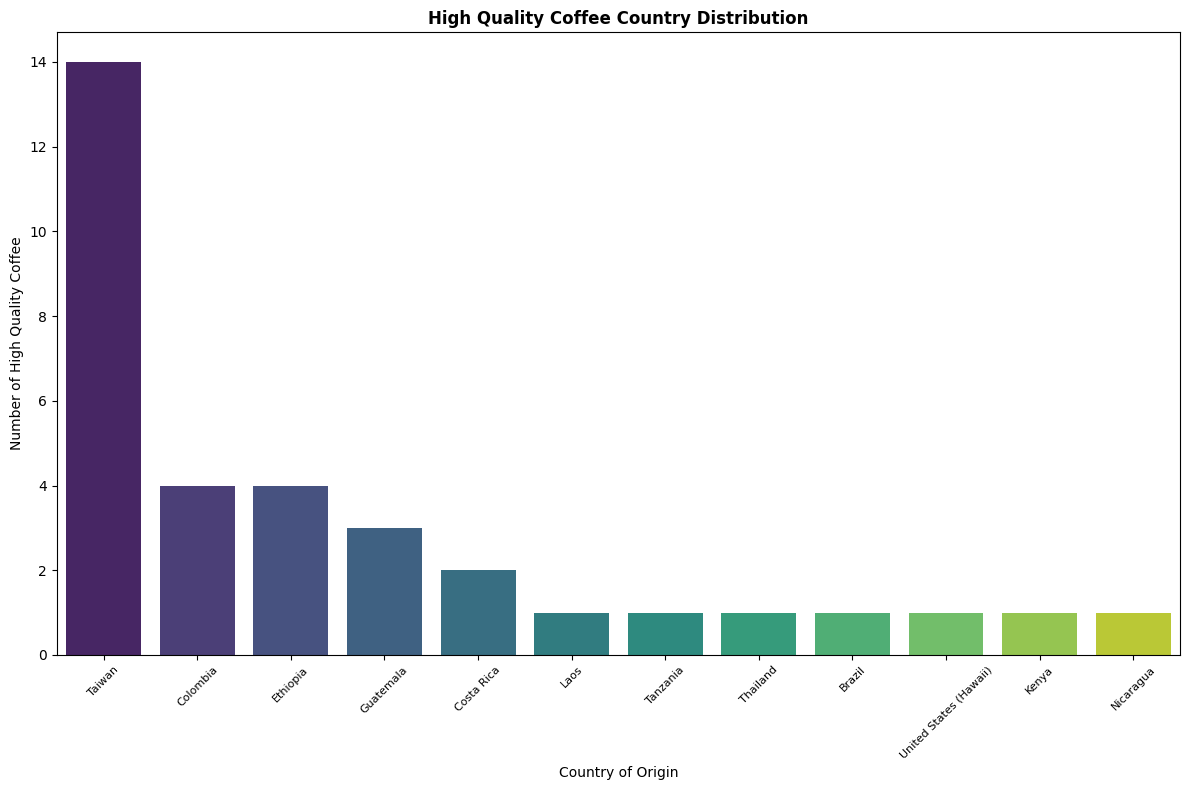

In [24]:
altered_df = df[df['Overall'] >= 8.0]
altered_df.loc[altered_df['Country of Origin'] == 'Tanzania, United Republic Of', 'Country of Origin'] = 'Tanzania'

country_counts = altered_df['Country of Origin'].value_counts().reset_index()
country_counts.columns = ['Country of Origin', 'Number of High Quality Coffee']

plt.figure(figsize=(12, 8))
sns.barplot(x='Country of Origin', y='Number of High Quality Coffee', data=country_counts, palette='viridis', hue='Country of Origin')

plt.title('High Quality Coffee Country Distribution', weight='bold')
plt.xlabel('Country of Origin')
plt.ylabel('Number of High Quality Coffee')
plt.xticks(rotation=45, size=8)

plt.tight_layout()
plt.show()

Nota-se que países de clima tropical possuem uma quantidade maior de cafés de alta qualidade. Dentre eles, Taiwan possui uma clara vantagem em relação aos demais, possuindo 14 cafés com qualidade alta. É plausível imaginar que cafés de origem taiwanesa apareçam entre os melhores cafés registrados.

### Comparação entre os 5 melhores cafés em termos de qualidade geral, considerando algumas características importantes como sabor e aroma

Existem diversas maneiras de classificar a qualidade de um café. Iremos analisar os 5 melhores cafés de acordo com as seguintes características: sabor, aroma, doçura e o gosto residual do café.

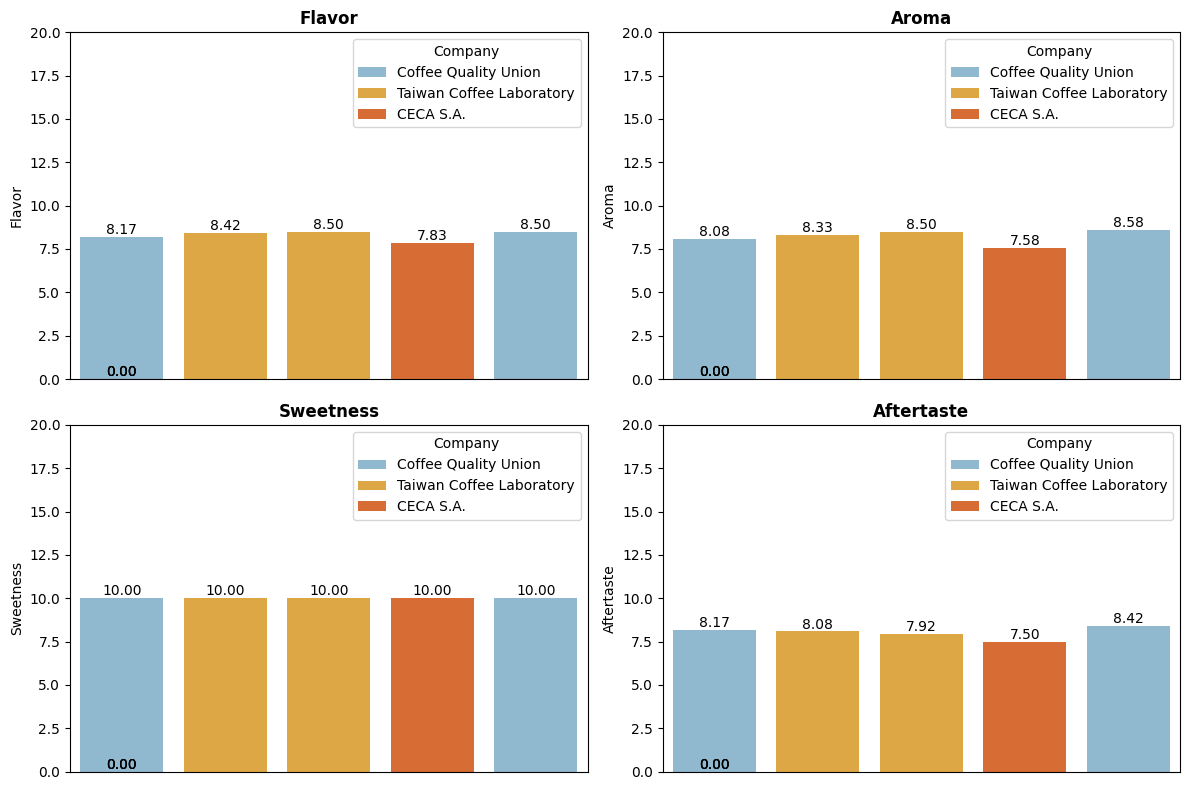

In [26]:
bar_data = df.sort_values('Overall')[-5:]
bar_data = bar_data[['Company', 'Flavor', 'Aroma', 'Sweetness', 'Aftertaste']]

categories = ['Flavor', 'Aroma', 'Sweetness', 'Aftertaste']
colors = ['#86BBD8', '#F6AE2D', '#F26419']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for i, c in enumerate(categories):
    row = i // 2
    col = i % 2
    ax = axes[row, col]

    data = bar_data[['Company', c]] # Gets the values of the category divided by company

    sns.barplot(data=data, x=np.arange(len(bar_data)), y=c, hue='Company', dodge=False, ax=ax, palette=colors)

    ax.set_xticks([]) # Removes x label
    ax.set_ylabel(c)

    ax.set_title(c, weight='bold')
    ax.set_ylim((0, 20))

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, title='Company')

    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

Como era esperado, Taiwan detém dois dos 5 melhores cafés, porém não é a detentora do café de melhor qualidade. Esse posto pertence a Colômbia, país de origem do café da Coffee Quality Union.

### Gráfico que mostra o desempenho geral dos cafés da marca que detém o café de melhor qualidade, durante os anos 2022-2023

Vamos analisar o desempenho dos cafés da Coffee Quality Union, em termos de qualidade geral, no período de 07/2022 a 04/2023.

#### Utility Functions

In [5]:
def _clean(date_str):
    pattern = r'(\d+)(st|nd|rd|th)'
    match = re.search(pattern, date_str)
    if match:
        number = match.group(1)
        return date_str.replace(match.group(), number)
    else:
        return date_str

In [6]:
def convert_date(date_str):
    clean = date_str.apply(_clean)
    return pd.to_datetime(clean, format='%B %d, %Y')

#### Graph Plot

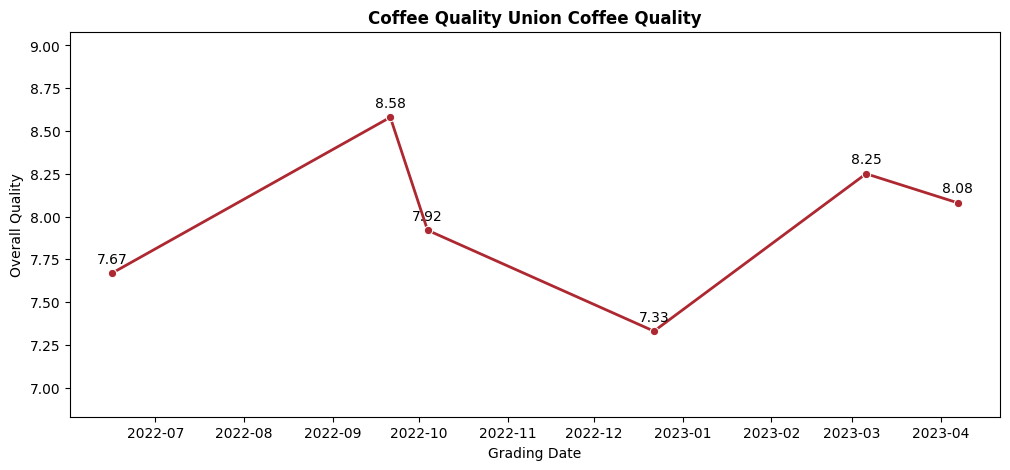

In [8]:
company = df.sort_values('Overall').iloc[-1]['Company']
line_data = df[df['Company'] == company][['Company', 'Overall', 'Grading Date']] # Filters all registers of the overall best company's coffee over time

# Converting 'Grading Date' field to Date
line_data['Grading Date'] = convert_date(line_data['Grading Date'])

# Removing duplicates, that is, two different types of coffee that were graded on the same day. The coffee with overall best quality is kept.
line_data = line_data.sort_values('Overall', ascending=False)
line_data = line_data.drop_duplicates('Grading Date', keep='first')
line_data = line_data.sort_values('Grading Date') # Sorting the values based on the grading date

plt.figure(figsize=(12, 5))

sns.lineplot(data=line_data, x='Grading Date', y='Overall', linewidth=2, marker='o', color='#AD2831')

for x, y in zip(line_data['Grading Date'], line_data['Overall']):
  plt.annotate(format(y, '.2f'), (x, y), ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

plt.title(f'{company} Coffee Quality', weight='bold')
plt.xlabel('Grading Date')
plt.ylabel('Overall Quality')

plt.ylim(line_data['Overall'].min() - 0.5, line_data['Overall'].max() + 0.5)

plt.show()

Como pode-se observar, a qualidade do café produzido pela Coffee Quality Union é sempre alta, mas com picos consideráveis em setembro de 2022, onde o valor foi consideravelmente mais alto, e janeiro de 2023, onde foi mais baixo.